
1. run time 측정기

2. 크롤링 - 키워드를 받아서 넣고 검색해서 100개의 url 가져오기
crawld, parameter(키워드, 개수, 다음이 실린 것만 가져올지)

3. csv 가져와서 데이터프레임 만들기
없으면 생성, datetime이 행으로 들어감
url 열에 100개 들어감
마지막열에 url 총 개수


4. 시각화
개수 추이 선형 그래프로 보여줌

5. 파일로 저장

6. okt로 명사 형용사 동사 빈도수 top10개


7. csv는 파일이 깨짐 excel파일로 작업해야함


In [26]:
class Runtime():
    def __init__(self,f):
        self.func = f
        
    def __call__(self,keyword,many):
        start = dt.datetime.now()
        self.func(keyword,many)
        delta = dt.datetime.now() - start
        print('코드 실행시간은 ',delta)

In [40]:
@Runtime
def check_status(keyword,many):
    for i in range(many):
        url = 'https://search.daum.net/search?w=news&q={}&DA=PGD&spacing=0&p={}'.format(keyword,many) 
        response = requests.get(url) 
        print(response.status_code)
check_status('korea',10)

200
200
200
200
200
200
200
200
200
200
코드 실행시간은  0:00:04.028494


In [2]:
def neg_error(num):
    if num<1:
        my_error = ValueError('{}은 음수입니다.'.format(num))
        raise my_error
    return num

In [3]:
from bs4 import BeautifulSoup as bs
import requests
import re
import pandas as pd
import numpy as np
import csv
import os
import datetime as dt
from konlpy.tag import Okt




class CrawlD(object):
    def __init__(self,search,many,daum):
        self.search = search
        self.many = neg_error(many)
        self.daum = daum
        self.url = 'https://search.daum.net/search?w=news&q={}&DA=PGD&spacing=0&p='
        file_name= input('파일 이름을 입력하세요 : ')
        self.file = file_name + '.xlsx'
        self.df = pd.DataFrame()
    
    
    def make_url(self):
        return self.url.format(self.search)
    
    
 
    #키워드 바꾸기
    def get_search(self):
        return self.search
    def set_search(self,new_search):
        self.search = new_search
    new_search = property(get_search,set_search)
    # 개수 바꾸기
    def set_many(self,new_many):
        self.many = new_many
    def get_many(self):
        return self.many
    new_many = property(get_many,set_many)
    #모드 바꾸기
    def set_daum(self,new_daum):
        self.daum = new_daum
    def get_daum(self):
        return self.daum
    new_daum = property(get_daum,set_daum)
    
    
    def open_file(self):
        try:
            self.df = pd.read_excel(self.file,encoding = 'utf-8',index_col=0)
            print('{}이 열렸습니다'.format(self.file))
        except FileNotFoundError:
            print('파일을 만드세요')
    
    
    def get_news(self):
        
        start = dt.datetime.now()
        print('뉴스를 가져오기 시작합니다')
        num = CrawlD.num_gen()
        news_df = pd.DataFrame() 
        url_nums = int()
        link_set = set()
        date_pattern = re.compile('\d*.*전.*')
        daum_pattern=re.compile('^(http://v.media.daum.net/v/)[0-9]*')
        
        
        #최대 개수보다 적은 동안에 코드를 돌림
        while url_nums <= self.many:
            flag = len(link_set)
            url = CrawlD.make_url(self)+str(next(num))
            html = bs(requests.get(url).text)
            
            #날짜를 확인하기 위한 태그들 가져옴
            tags = html.find_all('span',{'class':'f_nb date'})
            if self.daum == True:
                for tag in tags:
                    first = date_pattern.match(tag.text)
                    if first:
                        second = tag.find_all('a')
                        for third in second:
                            link_set.add(third.attrs['href'])
            url_nums = len(link_set)          
            #한 페이지 이상 새로운 뉴스가 없는 경우에는 새로운 뉴스가 없다고 판단하고 break
            if flag == url_nums:
                print('뉴스를 모두 추가했습니다.')
                break
        
        link_list = list(link_set)
        
        #가져온 게 더 많을 경우 차감해줌
        difference = self.many - url_nums
        if difference < 0 :
            link_list = link_list[:difference]
        url_nums = len(link_list)
        
        
        print('빈도 분석을 실시합니다.')
        #빈도 분석 코드
        keywords = CrawlD.analysis(self,link_list)
        
        
        date = dt.date.today()
        
        
        #새로운 뉴스를 기존의 데이터에 append
        new_news = pd.Series([date,self.search,link_list,url_nums,keywords],
                             index = ['date','search word','urls','total number','keywords'])
        self.df= self.df.append(new_news,ignore_index=True)
        
        delta = dt.datetime.now() - start
        print('코드 실행시간은 ',delta)
        print('='*50)
        print('현재 가져온 데이터')
        return self.df
    
    
    #파일을 불러온 파일 이름으로 덮어서 저장함
    def to_excel(self):
        self.df.to_excel(self.file,index=True,encoding='utf-8')
        print('{}이 {}에 저장되었습니다.'.format(self.file,os.getcwd()))
    
    

    def num_gen():
        n=1 
        while True:
            yield n
            n+=1  
            


    #자연어 처리, 날짜 키워드 입력하여 해당 url 자연어 분석
    def analysis(self,url_list):
        full_text = str()
        urls = url_list
        #공백, 탭, 줄바꿈 등 불필요한 문자들 제거하기 위함
        a_pattern=re.compile('&nbsp;|\t|\r|\n|\xa0')
        for url in urls:
            html = bs(requests.get(url,'html.parser').text)
            #main기사를 가져오는 태그
            body = html.find('div',{'id':'mArticle'})
            if body:
                text=body.get_text()
                clean_txt=re.sub(a_pattern,'',text)
                #분석의 용이성을 위해서 하나의 스트링으로 붙임
                full_text+=clean_txt
        #okt를 활용한 형태소 분석
        okt = Okt()
        stem_list = list()
        #목표 형태인 명사,형용사,동사를 리스트로 주고 여기에 해당하는 경우에 추가
        target = ['Noun','Adjective','Verb']
        for stems in okt.pos(full_text,stem=True):
            if stems[1] in target:
                stem_list.append(stems)
        stem_df = pd.DataFrame(stem_list,columns=['word','stem'])
        #valuecount로 빈도수 분석 후 상위 10개 리턴
        top_counts = stem_df['word'].value_counts().iloc[:10].index.to_list()
        return top_counts


In [43]:
#시각화
import matplotlib.pyplot as plt


class Visual(object):
    def __init__(self,df,year,month,day):
        self.title= str()
        self.df = df
        self.date = dt.date(year,month,day)   
    def plot(self):
        select_df = self.df[self.df['date']==self.date]
        ready2plot = select_df['total number']
        ready2plot.index = select_df['search word']
        ready2plot = pd.DataFrame(ready2plot)
        ready2plot.plot(kind='bar')
        plt.xlabel(self.date)
        plt.ylabel('total number')
        title = input('제목을 입력해주세요: ')
        plt.title(title)
        plt.show()
    def line_plot(self):
        search_word = input('단어를 입력해주세요 : ')
        select_df = self.df[self.df['search word']==search_word]
        ready2plot = select_df['total number']
        ready2plot.index = select_df['date']
        ready2plot.plot()
        plt.xlabel('date')
        plt.ylabel('total number trend')
        plt.title(search_word)

In [5]:
test2=CrawlD('EU',-1,True)

ValueError: -1은 음수입니다.

In [47]:
test1 = CrawlD('EU',100,True)

파일 이름을 입력하세요 : test


In [22]:
test1.make_url()

'https://search.daum.net/search?w=news&q=EU&DA=PGD&spacing=0&p='

In [59]:
test1.open_file()

test.xlsx이 열렸습니다


In [60]:
test1.df

,date,keywords,search word,total number,urls
0,2020-06-30,"['하다', '있다', '되다', '것', '공감', '이', '집행', '기금',...",EU,18,['http://v.media.daum.net/v/20200629070718055'...
1,2020-06-30,[],corona,0,[]
2,2020-06-30,"['공감', '하다', '재', '여성', '연합뉴스', '명', '사망', '돼다...",trump,7,['http://v.media.daum.net/v/20200629231703548'...
3,2020-06-28,NaN,EU,25,NaN
4,2020-06-29,NaN,EU,10,NaN
5,2020-06-30,"['공감', '하다', '베스트', '보기', '연재', '관련', '태그', '더...",korea,14,['http://v.media.daum.net/v/20200630141826911'...
7,2020-06-30,"['하다', '중계', '공감', '오픈', '스포츠', '폭스', '늘다', '되...",US,6,['http://v.media.daum.net/v/20200630152107684'...


In [61]:
visual = Visual(test1.df,2020,6,30)

C:\Users\gustn\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and 'the values will not compare equal to the
'datetime.date'. To retain the current behavior, convert the
'datetime.date' to a datetime with 'pd.Timestamp'.
  # This is added back by InteractiveShellApp.init_path()


제목을 입력해주세요: test


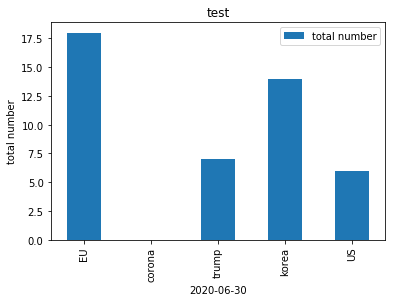

In [62]:
visual.plot()

단어를 입력해주세요 : EU


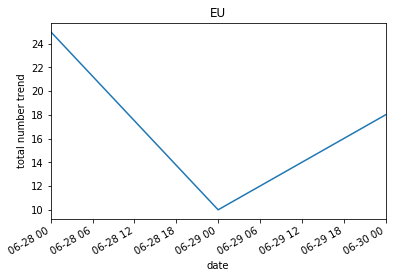

In [63]:
visual.line_plot()

In [ ]:
test1.new_ser

In [20]:
test1.to_excel()

test.xlsx이 C:\Users\gustn\bigdataprogramming에 저장되었습니다.
